Version notes:
- try other bond characteristics

# ML Analysis

In [1]:
import pandas as pd
import numpy as np

## Data
Data are from 'data_cleaning.ipynb', which uses a subset of merged TRACE and Mergent FISD daily bond data. It follows the sample exclusion criteria of Bai, Bali & Wen (2019) and aggregates returns to monthly based on their methodologies.

Following Moritz and Zimmerman (2016) (MZ), the goal is to estimate the expected return of stock i in time period t+1, conditional on information in period t.

In the context of corporate bonds, our aim will be to predict the return of bond i. Then based on the predicted return for t+1, bonds are sorted into deciles based on the expected return, and the trading strategy goes long the top decile (ie. highest predicted returns) and short the bottom decile. The out-of-sample test is implemented on a rolling basis: the model is estimated every year, using data from the past 5 years. Returns are predicted for the next 12 months, and in each month the decile portfolio strategy is implemented.

Given the bond characteristics, such as credit rating, duration, and yield-to-maturity (which are all known factors to affect returns), three types of return models can be implemented. The first can focus on raw returns, the second could focus on returns in "excess" of these other factors, and the third can incorporate these characteristics and return-based factors simultaneously. The first model ignores potential correlation between the return-based factors and other bond characteristics, however it follows Moritz and Zimmerman's methodology. The second model would involve first orthogonalizing returns to the bond factors (using linear regression), and then predicting the residual returns; this is appealing, but introduces estimation uncertainty (ie. what if the relationship is non-linear). Lastly, the third methodology is the most flexible. For example, it may be optimal to first sort on duration, and then on past returns etc. 


Thus, the outcome variables (ie. to be predicted) is the next month's return, up to the next 11 months. ~~To simplify things, it may be worthwhile to consider a buy-and-hold strategy: estimate the model, predict the next cummulative X month return (say 3 or 12 months), sort stocks, and go long/sort the portfolios with a holding period of X months. This would have significantly less turnover and hence less transaction costs. This could be used as a robustness check.~~ (This is impractical data wise)

The predictor variables are the past 24 months of 1 month returns (ie. the return over month t-k to t-k+1 for k = (1,...24)). The notation used by Moritz and Zimmerman is $ R_{i,t}(k,1) $. Thus the tree-based model effectively estimates a more complicated version of:

$
r_{i,t+1} = \mu_{1t} I(R_{i,t}(k,1) \lt \tau_t) + \mu_{2t} I(R_{i,t}(k,1) \ge \tau_t)
$

Where $\mu_1t$ can be interpreted as the return on a portfolio for which all stocks $i$ satisfy $R_{i,t}(k,1) \lt \tau_t$ in period $t$. Hence instead of simply sorting on a particular decile, stocks are sorted deeply on potentially many different criteria.

In terms of implementation practicicality, the ML model can be estimated akin to the Fama-MacBeth procedure. Using the past 5 years (60 months) of data, predictions can be formed. The estimation is over the time-dimension (in an OLS framework equivalent to averaging the results of 60 cross-sectional regressions), while the prediction is over the cross-sectional dimension (ie. bonds are ranked by highest return in the next cross-section). 

Hence the data should be indexed at the bond-month level (ie. all predictors and outcomes should be aligned to month t for bond i). Thus estimating a model for bond i using data from t-60 to t is equivalent to a pooled cross-section. 

In [2]:
data = pd.read_csv('monthly_data.csv', index_col=0)

In [3]:
data.head()

,date,issue_id,cusip_id,volume,issuer_id,prospectus_issuer_name,maturity,offering_amt,interest_frequency,cusip,...,rating_spr,rating_mdy,amount_outstanding,tau,age,ytm,duration,tr_dirty_price,tr_ytm,return
0,2002-08-31,98694,010392DN5,25000.0,86.0,ALABAMA PWR CO,2004-08-15,250000.0,2.0,010392DN5,...,A,A2,250000.0,1.972603,3.038356,3.672086,1.872172,109.77133,2.142072,-0.024568
1,2002-08-31,99961,010392DP0,15000.0,86.0,ALABAMA PWR CO,2007-10-01,200000.0,2.0,010392DP0,...,A,A2,200000.0,5.101370,2.931507,4.540522,4.299664,120.46437,3.339660,0.013677
2,2002-08-31,144179,00079FAW2,20000.0,37284.0,ABN AMRO BK N V,2003-12-19,4500.0,2.0,00079FAW2,...,AA,Aa2,4500.0,1.315068,0.200000,12.814093,1.230101,115.34654,1.844255,0.006316
3,2002-08-31,97686,013104AE4,215000.0,93.0,ALBERTSONS INC,2009-08-01,350000.0,2.0,013104AE4,...,BBB+,Baa1,350000.0,6.936986,3.098630,5.601379,5.647303,119.27208,3.834566,-0.001913
4,2002-08-31,102864,029050AB7,2000000.0,33708.0,AMERICAN PLUMBING & MECHANICAL,2008-10-15,125000.0,2.0,029050AB7,...,B-,B3,125000.0,6.142466,2.734246,29.812586,3.527641,148.25096,3.569999,0.012265


## Summary Stats

In [4]:
# Chronological order, indexes by month-bond
data = data.sort_values(by=['date', 'issue_id'])
data = data.set_index(['date', 'issue_id'])

In [5]:
print('There are', len(data.index.get_level_values(0).unique()), ' unique months in the panel')

There are 234  unique months in the panel


In [6]:
bond_count = {}
for month in data.index.get_level_values(0).unique():
    bond_count[month] = len(data.loc[month])

bonds = pd.DataFrame.from_dict(bond_count, orient='index', columns=['Bond Count'])

In [7]:
print('There are on average ', bonds.describe().loc['mean'][0].astype(int), 
      ' bonds in each monthly cross-section, with as few as ', bonds.describe().loc['min'][0], 
      ' and as many as ', bonds.describe().loc['max'][0])

There are on average  373  bonds in each monthly cross-section, with as few as  190.0  and as many as  594.0


## Outcome-Predictor Organization

Since predictors and outcomes are both returns, the notation will follow from MZ, where predictors will be denoted as R(k,1) (ie. the historical 1 month return for month k), while the outcome will be denoted as r(k,t) (ie. the t-month cummulative return of holding the bond k months ahead). As mentioned previously, the main outcomes will be {r(1,1),...,r(12,1)} ~~as well as {r(1,3),r(1,12)}.~~

In [8]:
df = data.copy().reset_index()

In [9]:
# Risk-free rate
crsp_data = pd.read_csv("crsp_data.csv", index_col='MthCalDt', parse_dates=True)
crsp_data = crsp_data.pivot(columns="IndNm", values='COL1')
crsp_data.index = crsp_data.index + pd.tseries.offsets.MonthEnd(0)
crsp_data.columns = ['20y_return', 'rf', '30y_return', '90day', 'mkt']
crsp_data.index.name = 'Date'

risk_free = crsp_data['rf'].loc[data.index[0][0]:data.index[-1][0]]

In [10]:
# Excess Returns
df['excess_return'] = df['return'] - df.groupby('date')['date'].transform(lambda x: risk_free.loc[x.iloc[0]])
df = df.set_index(['date', 'issue_id'])

In [11]:
# Predictors: Past 1-month Returns
for i in range(24):
    df['R('+str(i)+',1)'] = df.groupby(level=1)['excess_return'].shift(i+1)

In [12]:
# Outcomes:
# 12 months of 1-month returns
for i in range(12):
    df['r('+str(i+1)+',1)'] = df.groupby(level=1)['excess_return'].shift(-(i+1))

In [13]:
# df.to_csv('model_data.csv')

## Model Estimation

Several models can be implemented. 

1) OLS
- All 24 past returns can be used as predictors

~~2) Regularization~~
- ~~Same predictors as OLS, but can include all combinations of 2 or 3 way interactions~~
- ~~LASSO seems like an obvious candidate~~

3) Regression Tree
- Can be used to demonstrate the underlying mechanics and interpretation
- Will likely overfit, but still worthwhile to implement

4) Random Forest
- Follows from MZ

5) XGBoost
6) Neural Network???

Regardless of which model is implemented, the out-of-sample procedure is identical. Specifically, the out-of-sample procedure is equivalent to a rolling train-test split which would be akin to what a researcher would implement in real time. 

MZ don't explicitly use cross-validation to tune hyperparameters, noting "we construct 200 tree-based conditional portfolio sorts and we use 8 out of 25 regressors in each of them. We have tried other values for the [hyperparameters] but have found that results do not vary much with these choices. We settled on the share of 30 percent of regressors because it is a standard 
recommendation in the random forest literature, and we chose B = 200 because higher values did not have any apparent benefit for the estimation but are more costly in terms of computation."

The out-of-sample procedure is as follows:
1) Estimate the model using data from the past 5 years (60 months)
2) Predict returns for the next 12 months
3) Based on the predictions, for each month, sort bonds into ~~deciles~~ quintiles, and go long the top ~~decile~~ and short the bottom ~~decile~~ quintiles
4) The trading strategy rebalances monthly based on the rankings from the previous step
5) After 1 year, the model is re-estimated and the process repeats

An alternative strategy, which would reduce monthly turnover, could re-rank bonds based on their average decile over the next 12 months, and then go long/short the top/bottom decile of the second-order sorting. The long/short would be held for the next 12 months, and the strategy would be rebalanced annually. 

Note: Quintiles are used due to the limited sample in each cross-section.

In [2]:
# Models
from statsmodels.api import OLS
from sklearn.tree import DecisionTreeRegressor as tree
from sklearn.ensemble import RandomForestRegressor as forest
from sklearn.neural_network import MLPRegressor as neural_net
from xgboost import XGBRegressor as xgboost
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz, export_text

In [3]:
df = pd.read_csv('model_data.csv').sort_values(by=['date', 'issue_id']).set_index(['date', 'issue_id'])

In [4]:
model_data = df.loc["2004-7":].dropna()

In [5]:
X = model_data.loc[:,'R(0,1)':'R(23,1)']
Y = model_data.loc[:,'r(1,1)':'r(12,1)']

<AxesSubplot:ylabel='Frequency'>

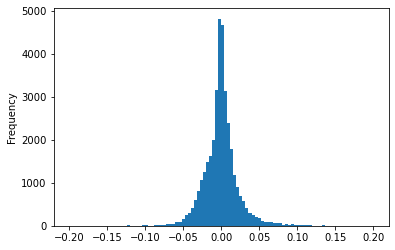

In [6]:
X['R(0,1)'].plot.hist(bins=100, range=[-0.2,0.2])

In [7]:
# Standardizes the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

X_scaled = pd.DataFrame(scaled_X, columns=X.columns, index=X.index)

In [8]:
# Handles missing data (???)

In [9]:
def model_est(model_name,y,x,start):
    '''
    Function to train a model on the data. Outputs predicted values. 
    'start' should be incremented by 12 for the model to be re-estimated every 12 months.
    'model_name' should be 'ols', 'tree', 'forest', 'neural_net', 'xgboost'.
    '''
    Y = y.loc[y.index.levels[0][30:].values[start:start+60]]
    X = x.loc[x.index.levels[0][30:].values[start:start+60]]
    
    # Estimates the model
    if model_name=='ols':
        model = OLS(Y,X).fit()
    
    if model_name=='tree':
        model = tree(splitter='best', max_depth=100, random_state=1).fit(X,Y)
    
    if model_name=='forest':
        model = forest(n_estimators=200, max_depth=25, max_features=8, random_state=1).fit(X,Y) # based on MZ
    
    if model_name=='neural_net':
        model = neural_net(hidden_layer_sizes=(24, 12, 6), activation='relu', 
                           solver='sgd', random_state=1).fit(X,Y) # 3 hidden layers with neurons as per Gu, Kelly, Xiu (2019)
    
    if model_name=='xgboost':
        model = xgboost(n_estimators=200, max_depth=5, subsample=0.8, random_state=1).fit(X,Y) # similar parameters to forest


    # Optimized Models
    if model_name=='tree_optimal':
        model = tree(splitter='best', max_depth=25, random_state=1).fit(X,Y)
    
    if model_name=='forest_optimal':
        model = forest(n_estimators=150, max_depth=15, max_features=2, min_samples_leaf=15, random_state=1).fit(X,Y) # based on MZ
    
    if model_name=='neural_net_optimal':
        model = neural_net(hidden_layer_sizes=(24, 12, 6), activation='relu', 
                           solver='sgd', alpha=0.1, random_state=1).fit(X,Y)
    
    if model_name=='xgboost_optimal':
        model = xgboost(n_estimators=150, max_depth=15, subsample=0.65, random_state=1).fit(X,Y) # similar parameters to forest
   

    # Model output
    Y_hat = model.predict(x.loc[x.index.levels[0][30:].values[start+60]]) # next month
    Y_true = y.loc[y.index.levels[0][30:].values[start+60]]
    
    if model_name=='ols':
        Y_hat.columns = Y.columns

    else:
        Y_hat = pd.DataFrame(Y_hat, columns=Y.columns, index=x.loc[x.index.levels[0][30:].values[start+60]].index)
    
    index = y.index.levels[0][30:][start+60:start+60+12]
    
    return (Y_hat, Y_true, index)

In [10]:
def index_forecast(y, y_hat, index, start):
    '''
    Function to multi-index a cross-section with the respective starting year.
    '''
    y_hat['date'] = index[0]
    y_hat = y_hat.reset_index().set_index(['date', 'issue_id'])
    
    return y_hat

In [11]:
def compute_deciles(df):
    '''
    Computes deciles of each column.
    '''
    deciles = df.apply(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'), axis=0)
    deciles.columns = df.columns+'_decile'
    
    return deciles

In [12]:
def value_weight(df, group, value, weight):
    '''
    Function to take the value-weighted average return for a particular decile.
    '''
    
    group_sum = (df[value] * df[weight]).groupby(df[group]).sum()
    group_weight = df[weight].groupby(df[group]).sum()
    
    group_weighted_avg = group_sum / group_weight
    
    return group_weighted_avg

In [13]:
def amt_out(y_hat, index):
    '''
    Function to organize the amount-outstanding for the purposes of value-weighting the return.
    It takes in the index corresponding to the forecast period. 
    '''
    
    # Subsets the amount outstanding, and converts index from dates to t+k ahead return
    amt = model_data["amount_outstanding"].loc[index]
    index_return = pd.DataFrame(y_hat.columns, index=index, columns=['return'])
    amt = amt.reset_index().merge(index_return, on='date').set_index(['return','issue_id']).drop('date', axis=1)
    
    # Gets the first value
    amt = amt.unstack(-1).bfill().ffill()
    amt = amt.iloc[0].to_frame()
    amt = amt.reset_index().set_index('issue_id').drop('level_0', axis=1)
    amt.columns = ['amt_out']

    return amt

In [14]:
def trading_strategy(y_hat, y_true, index, weight='value'):
    '''
    Function to output results of the trading strategy.
    The inputs are the results from the model: the fitted values and the true values
    '''
    # Computes return deciles based on fitted values
    deciles = compute_deciles(y_hat)
    
    # Merges deciles with actual values
    y_deciles = pd.concat([y_true, deciles], axis=1)
    y_deciles = pd.merge(y_deciles, amt_out(y_hat, index), how="left", on="issue_id")

    # Portfolio Formation
    columns = y_deciles.columns[:12]
    month_ahead_return_ew = []
    month_ahead_return_vw = []
    
    if weight == 'equal':
        # Equal-weighted average
        for column in columns:
            month_ahead_return_ew.append(y_deciles.groupby(column+'_decile')[column].mean())
        
        decile_portfolios = pd.concat(month_ahead_return_ew, axis=1)
            
    else:
    # Value-weighted average
        for column in columns:
            gwa = value_weight(y_deciles, (column+'_decile'), column, "amt_out")
            month_ahead_return_vw.append(gwa)
        decile_portfolios = pd.concat(month_ahead_return_vw, axis=1)

    decile_portfolios.index.names = ['decile']
    
    strategy_return = decile_portfolios.T[4] - decile_portfolios.T[0]
    strategy_return.index = index
    
    return strategy_return

In [15]:
def out_of_sample_procedure(model_name,y,x):
    '''
    Function to run the rolling annual model training and forecasting.
    Outputs the trading strategy return as well as the fitted values for each both for each month.
    'model_name' should be 'ols', 'tree', 'forest', 'neural_net', 'xgboost'.
    '''
    strat_returns = []
    actual_y = []
    forecast_y = []
    
    for step in np.arange(0,len(X.index.levels[0][30:].unique()),12)[:11]:
        y_hat, y_true, index = model_est(model_name, y, x, step)
        model = trading_strategy(y_hat, y_true, index)
        
        strat_returns.append(model)
        actual_y.append(index_forecast(y, y_true, index, step))
        forecast_y.append(index_forecast(y, y_hat, index, step))
        
    strat_returns_df = pd.concat(strat_returns)
    actual_y_df= pd.concat(actual_y)
    forecast_y_df = pd.concat(forecast_y)
    
    return (strat_returns_df, actual_y_df, forecast_y_df)

In [16]:
from sklearn.metrics import r2_score as R2

def results(model):
    '''
    Function to output R-Squared and cummulative strategy return plot.
    '''
    returns, y_true, y_hat = out_of_sample_procedure(model,Y,X)
    returns1, y_true1, y_hat1 = out_of_sample_procedure(model+'_optimal',Y,X)
    
    rets = pd.concat([returns,returns1], axis=1)
    rets.columns = ['Default','Optimal']
    (1+rets).cumprod().plot()
    print('Default R2: ', R2(y_true,y_hat), 'Optimal R2: ', R2(y_true,y_hat1))

-0.07181073108448154


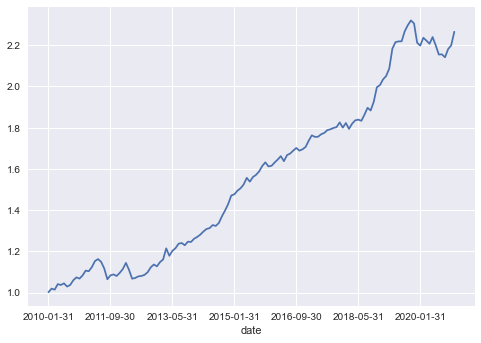

In [105]:
returns, y_true, y_hat = out_of_sample_procedure('ols',Y,X)
(1+returns).cumprod().plot()
print(R2(y_true,y_hat))

Default R2:  -1.0559267801502261 Optimal R2:  -0.8051611665688041


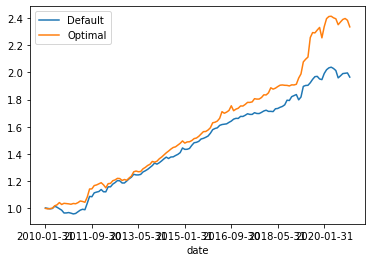

In [20]:
results('tree')

In [17]:
results('forest')

In [ ]:
results('neural_net')

In [ ]:
results('xgboost')

In [73]:
# # OLS Model Detailed Output
# from linearmodels.system.model import SUR
# model = SUR.multivariate_ls(Y, X).fit(cov_type='kernel', kernel='bartlett')
# print(model)

## Hyperparameter Tuning: Cross-Validation & GridSearch

Since we are working with unbalanced panel data, that is for every month we have a cross-section of bonds (which potentially differ each month), sklearn does not have a built-in cross-validation splitter which is appropriate for this type of data. Hence it is crucial to create a cross-validation splitter object which adheres to the principal of a time-series splitter (ie. not train on future data), while also being mindful of the cross-sectional dimension.

More generally with respect to cross-validation, the models and forecasts are computed on a rolling basis; this is akin to a rolling time-series cross-validation. The model is re-estimated every year, with data from the past 5 years. So it makes sense to incorporate a 5 fold time-series split; train on 1 year, validate on 1 (then train on 2, validate on the next etc). However this is computationally cumbersome since it would require grid searching 17 times (ie. every time a model is estimated). In particular due to the rolling nature, only 20% of the sample (ie. 1/5 years) will be "new" data, so potentially there will be similarity in the optimal hyperparameters across models. 

Therefore a sensible hyperparameter tuning strategy would be to initially tune the model, and keep those same hyperparameter estimates the same for the remainder of the sample. Another strategy would be to tune the model every 5 years, so that the cross-validation data is always fresh.

In [27]:
def cv_splitter(df):
    train = df.sort_values(by='date', ascending=True).reset_index()    

    month_index = []
    for month in train['date'].unique(): 
        month_index.append(train[train['date'] == month].shape[0])
    month_index = pd.DataFrame(month_index, index=train['date'].unique(), columns=['month_index'])
    month_index = month_index.cumsum()

    return [[list(range(0,month_index.iloc[i][0])), 
                        list(range(month_index.iloc[i][0],month_index.iloc[i+2][0]))] 
                           for i in np.arange(12,60,12)]

In [28]:
# split = cv_splitter(X)

In [29]:
# split[0][0]
# split[0][1]

Grid search below was non-exhaustive, but combinations were iterating manually.

In [51]:
from sklearn.model_selection import GridSearchCV

def param_tune(model):
    '''
    Function to tune the hyperparameters for the first 5 years of the sample.
    Uses a panel-based cross-validation splitter and grid-search over main hyperparamters
    '''
    
    # Model Parameters
    tree_params = {"max_depth":list(range(1,20)), "min_samples_leaf":list(range(1,20))}
    
    forest_params = {'n_estimators':[150,200,250], "max_depth":[15,20,25], 'max_features':[2,4,6,8], 'min_samples_leaf':[10,15,20,25]}
    
    hidden_layers = [(24,), (24,24), (24,12), (24,12,6), (24,12,12), (12,12,12), (24,24,24),
                     (48,), (48,48), (48,24), (48,24,12), (48,24,24), (48,48,48),
                     (96,), (96,96), (96,48), (96,48,24), (96,48,48), (96,96,96), (96,48,24,12), (96,48,24,12,6)]
    neural_net_params = {'hidden_layer_sizes':hidden_layers, 'alpha':[0.1, 0.01, 0.001, 0.0001, 0.00001]}

    xgboost_params = {'n_estimators':[150,200,250], 'max_depth':[15,20,25], 'subsample':[0.5,0.65,0.8]}

    # Models
    models = {'tree': {tree(splitter='best', random_state=1): tree_params},
              'forest': {forest(random_state=1): forest_params}, 
              'neural_net': {neural_net(activation='relu', solver='sgd', learning_rate='adaptive', random_state=1): neural_net_params}, 
              'xgboost': {xgboost(random_state=1): xgboost_params}}
    
    # Performs cross-validation over grid of parameters
    grid_search = GridSearchCV(list(models[model].keys())[0], 
                               list(models[model].values())[0], scoring='r2', cv=cv_splitter(X))
    grid_search.fit(X,Y)

    print('Best parameters:', grid_search.best_params_, "Accuracy score: ", grid_search.best_score_)

In [37]:
%%time
param_tune('tree')

Best parameters: {'max_depth': 1, 'min_samples_leaf': 1} Accuracy score:  -0.14135730235689425
CPU times: total: 46.6 s
Wall time: 1min 18s


Optimal tree does not work ({'max_depth': 1, 'min_samples_leaf': 1})

In [47]:
%%time
param_tune('forest')

Best parameters: {'max_depth': 15, 'max_features': 2, 'min_samples_leaf': 15, 'n_estimators': 150} Accuracy score:  -0.10213417155979834
CPU times: total: 9min 1s
Wall time: 16min 21s


Seems like forest is not very sensitive to number of trees; 50 to 200 seem to have marginal difference in accuracy (band of sub-1%). Could be a result of other parameters not being in their optimal ranges.

In [52]:
%%time
param_tune('neural_net')

Best parameters: {'alpha': 0.1, 'hidden_layer_sizes': (24, 12, 6)} Accuracy score:  -0.16421049053201417
CPU times: total: 16 s
Wall time: 5min 38s


In [53]:
%%time
param_tune('xgboost')

Best parameters: {'max_depth': 15, 'n_estimators': 150, 'subsample': 0.65} Accuracy score:  -0.793539577918309
CPU times: total: 2h 30min 45s
Wall time: 10min 35s


XGBoost default values do better?

## Results and Plots

### Quasi-Classification Accuracy

In [19]:
deciles_hat = compute_deciles(y_hat)
deciles_true = compute_deciles(y_true)

In [21]:
deciles_hat.columns

Index(['r(1,1)_decile', 'r(2,1)_decile', 'r(3,1)_decile', 'r(4,1)_decile',
       'r(5,1)_decile', 'r(6,1)_decile', 'r(7,1)_decile', 'r(8,1)_decile',
       'r(9,1)_decile', 'r(10,1)_decile', 'r(11,1)_decile', 'r(12,1)_decile'],
      dtype='object')

In [54]:
from sklearn.metrics import classification_report as acc
from sklearn.metrics import confusion_matrix as cfm

In [38]:
accuracy = {}
for col in deciles_hat.columns:
    accuracy[col] = acc(deciles_true[col], deciles_hat[col])

In [43]:
print(accuracy['r(1,1)_decile'])

              precision    recall  f1-score   support

           0       0.36      0.36      0.36       483
           1       0.19      0.19      0.19       483
           2       0.34      0.34      0.34       483
           3       0.18      0.18      0.18       483
           4       0.24      0.24      0.24       483

    accuracy                           0.26      2415
   macro avg       0.26      0.26      0.26      2415
weighted avg       0.26      0.26      0.26      2415



In [55]:
accuracy = {}
for col in deciles_hat.columns:
    accuracy[col] = cfm(deciles_true[col], deciles_hat[col])

In [57]:
accuracy['r(1,1)_decile']

array([[173, 105,  72,  73,  60],
       [ 57,  92, 130, 134,  70],
       [ 34,  70, 165, 137,  77],
       [ 59, 108,  70,  86, 160],
       [160, 108,  46,  53, 116]], dtype=int64)

In [61]:
y_true

r(1,1)    r(2,1)    r(3,1)    r(4,1)    r(5,1)  \
date       issue_id                                                     
2010-01-31 38        0.003667 -0.040628  0.007423  0.015629  0.011068   
           49        0.008665  0.021510 -0.008683  0.003572 -0.029274   
           173       0.003725 -0.033184  0.003793  0.008166  0.012982   
           175      -0.032220 -0.002318  0.011005  0.042970  0.034067   
           433       0.002551 -0.005332  0.004778  0.006993 -0.019425   
...                       ...       ...       ...       ...       ...   
2020-01-31 724575    0.077951  0.067481  0.026515 -0.049705  0.001424   
           727093    0.013674  0.015343  0.002434  0.002071 -0.012967   
           727095    0.031997  0.029139  0.006473  0.002591  0.001311   
           729007    0.020459  0.023321  0.003377  0.003323 -0.018944   
           749578    0.029603  0.016129  0.004383  0.003665  0.001371   

                       r(6,1)    r(7,1)    r(8,1)    r(9,1)   r(10,1)  \
date       issue_id                                                     
2010-01-31 38        0.018122 -0.026722  0.002048 -0.005614 -0.024971   
           49       -0.000279  0.013290  0.025172  0.006480 -0.030356   
           173       0.002918  0.008098 -0.024918  0.002705 -0.002945   
           175      -0.000827  0.035087 -0.005642 -0.010702 -0.012216   
           433       0.005479  0.003935  0.004604 -0.003640 -0.035567   
...                       ...       ...       ...       ...       ...   
2020-01-31 724575    0.045720 -0.032217 -0.007564 -0.039564  0.007712   
           727093    0.001653 -0.000679  0.000203 -0.000788  0.000464   
           727095   -0.007113 -0.007909  0.005113 -0.011547  0.002819   
           729007    0.004194 -0.002746  0.000965 -0.004629  0.001483   
           749578    0.005576 -0.004261 -0.008720 -0.006955  0.002078   

                      r(11,1)   r(12,1)  
date       issue_id                      
2010-01-31 38        0.009731 -0.006034  
           49        0.021411  0.016172  
           173      -0.005277  0.002197  
           175      -0.035535 -0.001246  
           433       0.001590 -0.000004  
...                       ...       ...  
2020-01-31 724575   -0.021459 -0.005029  
           727093   -0.013070  0.000138  
           727095   -0.000940 -0.022120  
           729007   -0.019701 -0.002776  
           749578    0.000058 -0.010196  

[2415 rows x 12 columns]

In [62]:
rsq = {}
for col in y_true.columns:
    rsq[col] = R2(y_true[col], y_hat[col])

In [63]:
rsq

{'r(1,1)': -0.054541194893782396,
 'r(2,1)': -0.0050576966019859615,
 'r(3,1)': -0.11466145251598348,
 'r(4,1)': -0.14514834242632912,
 'r(5,1)': -0.03363458686867471,
 'r(6,1)': -0.1053329012586961,
 'r(7,1)': -0.13236786775296183,
 'r(8,1)': -0.15061729765819942,
 'r(9,1)': -0.050671078163275984,
 'r(10,1)': -0.03365176994722652,
 'r(11,1)': -0.00948615055479407,
 'r(12,1)': -0.026558434371868778}

### Plots

In [18]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
plt.style.use('seaborn')

#### Feature Importance

In [100]:
def feature_importance(model):
    '''
    Function to create feature importance dataframe for every model.
    '''
    importance = permutation_importance(model, X, Y, scoring='r2', random_state=1)
    
    return pd.DataFrame(importance['importances_mean'], index=X.columns, columns=['Feature Importance'])

In [36]:
model_tree = tree(splitter='best', max_depth=25, random_state=1).fit(X,Y)

model_forest = forest(n_estimators=150, max_depth=15, max_features=2, min_samples_leaf=15, random_state=1).fit(X,Y)

model_nn = neural_net(hidden_layer_sizes=(24, 12, 6), activation='relu', 
                       solver='sgd', alpha=0.1, random_state=1).fit(X,Y)

model_xgboost = xgboost(n_estimators=150, max_depth=15, subsample=0.65, random_state=1).fit(X,Y)

In [63]:
importances = pd.concat([feature_importance(model_tree), feature_importance(model_forest),
                        feature_importance(model_nn), feature_importance(model_xgboost)], axis=1)
importances.columns = ['Tree', 'Forest', 'Neural Network', 'XGBoost']

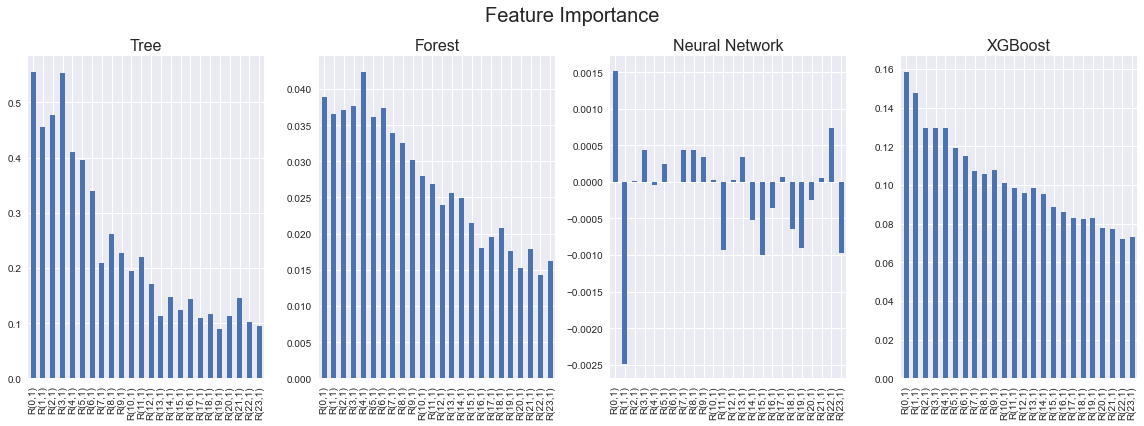

In [111]:
fig, ax = plt.subplots(1, 4, figsize=(16,6))

fig.suptitle('Feature Importance', fontsize=20)

ax1 = importances["Tree"].plot.bar(ax=ax[0])
ax1.set_title('Tree', fontsize=16)
ax1.set_xlabel("")

ax2 = importances["Forest"].plot.bar(ax=ax[1])
ax2.set_title('Forest', fontsize=16)
ax2.set_xlabel("")

ax3 = importances["Neural Network"].plot.bar(ax=ax[2])
ax3.set_title('Neural Network', fontsize=16)
ax3.set_xlabel("")

ax4 = importances["XGBoost"].plot.bar(ax=ax[3])
ax4.set_title('XGBoost', fontsize=16)
ax4.set_xlabel("")

fig.tight_layout()
plt.show()

# plt.savefig('Feature Importance.jpg')

#### OLS Feature Importance

In [17]:
from linearmodels.system.model import SUR
model = SUR.multivariate_ls(Y, X).fit(cov_type='kernel', kernel='bartlett')

In [98]:
t_stats = model.tstats.to_frame().reset_index()
# t_stats['tstat'] = abs(t_stats['tstat'])

In [99]:
features = t_stats['index'].str.extract(r'(R.*)')
outcomes = t_stats['index'].str.extract(r'(r.*)_')
features.columns = ['Feature']
outcomes.columns = ['Outcome']

In [100]:
t_stats = pd.concat([t_stats, features, outcomes], axis=1)

In [101]:
tstats_df = t_stats.pivot(columns='Feature', index='Outcome', values='tstat').T.reindex(index=X.columns, columns=Y.columns)

In [110]:
# abs(tstats_df).mean(1).plot.bar()

Text(0, 0.5, 'Count of t-stats above |2.0|')

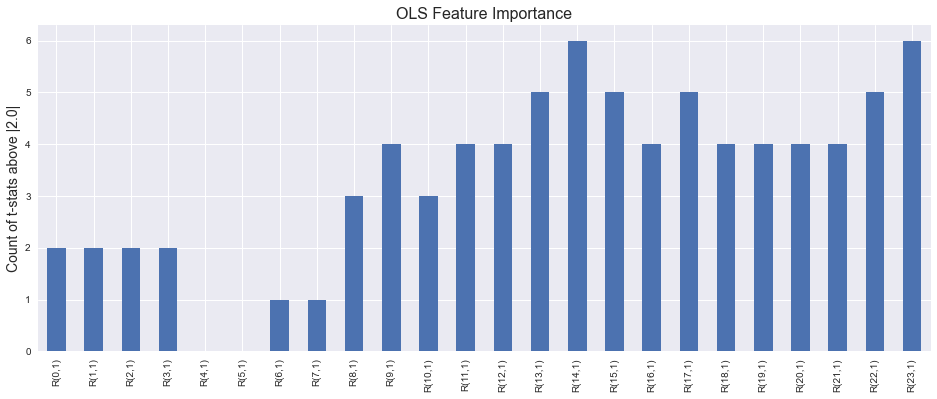

In [122]:
fig, ax = plt.subplots(figsize=(16,6))

ax = (abs(tstats_df)>2).sum(1).plot.bar()
ax.set_title('OLS Feature Importance', fontsize=16)
ax.set_xlabel("")
ax.set_ylabel("Count of t-stats above |2.0|", fontsize=14)

# plt.savefig('OLS Feature Importance.jpg')

#### Strategy Returns

In [31]:
def plot_trading_strategy(y_hat, y_true, index, weight='value'):
    '''
    Function to output results of the trading strategy.
    The inputs are the results from the model: the fitted values and the true values
    '''
    # Computes return deciles based on fitted values
    deciles = compute_deciles(y_hat)
    decilestrue = compute_deciles(y_true)
   
    # Merges deciles with actual values
    y_deciles = pd.concat([y_true, deciles], axis=1)
    y_deciles = pd.merge(y_deciles, amt_out(y_hat, index), how="left", on="issue_id")

    # Portfolio Formation
    columns = y_deciles.columns[:12]
    month_ahead_return_ew = []
    month_ahead_return_vw = []
    
    if weight == 'equal':
        # Equal-weighted average
        for column in columns:
            month_ahead_return_ew.append(y_deciles.groupby(column+'_decile')[column].mean())
        
        decile_portfolios = pd.concat(month_ahead_return_ew, axis=1)

            
    else:
    # Value-weighted average
        for column in columns:
            gwa = value_weight(y_deciles, (column+'_decile'), column, "amt_out")
            month_ahead_return_vw.append(gwa)
        decile_portfolios = pd.concat(month_ahead_return_vw, axis=1)

    decile_portfolios.index.names = ['decile']
    decile_top = decile_portfolios.T[4]
    decile_bottom = decile_portfolios.T[0]
    strategy_return = decile_portfolios.T[4] - decile_portfolios.T[0]
    strategy_return.index = index
    
    return (strategy_return, decile_top, decile_bottom)

In [32]:
def plot_out_of_sample_procedure(model_name,y,x):
    '''
    Function to run the rolling annual model training and forecasting.
    Outputs the trading strategy return as well as the fitted values for each both for each month.
    'model_name' should be 'ols', 'tree', 'forest', 'neural_net', 'xgboost'.
    '''
    strat_returns = []
    top_decile = []
    bottom_decile = []
    
    for step in np.arange(0,len(X.index.levels[0][30:].unique()),12)[:11]:
        y_hat, y_true, index = model_est(model_name, y, x, step)
        model, top, bottom= plot_trading_strategy(y_hat, y_true, index)
        
        strat_returns.append(model)
        top_decile.append(top)
        bottom_decile.append(bottom)
       
        
        
    strat_returns_df = pd.concat(strat_returns)
    top_df= pd.concat(top_decile)
    bottom_df= pd.concat(bottom_decile)
     

    return (strat_returns_df, top_df, bottom_df)

In [33]:
ols_returns, ols_top, ols_bottom = plot_out_of_sample_procedure('ols',Y,X)
# tree_returns = out_of_sample_procedure('tree',Y,X)[0]
# forest_returns = out_of_sample_procedure('forest',Y,X)[0]
# nn_returns = out_of_sample_procedure('neural_net',Y,X)[0]
# xg_returns = out_of_sample_procedure('xgboost',Y,X)[0]

In [60]:
def strat_return():
    '''
    Function to create dataframes for plots of strategy returnss
    '''
    
    # Run models and store results
    ols_returns, ols_top, ols_bottom = plot_out_of_sample_procedure('ols',Y,X)
    tree_returns, tree_top, tree_bottom = plot_out_of_sample_procedure('tree_optimal',Y,X)
    forest_returns, forest_top, forest_bottom = plot_out_of_sample_procedure('forest_optimal',Y,X)
    nn_returns, nn_top, nn_bottom = plot_out_of_sample_procedure('neural_net_optimal',Y,X)
    xg_returns, xg_top, xg_bottom = plot_out_of_sample_procedure('xgboost_optimal',Y,X)

    model_names = ['OLS', 'Tree', 'Forest', 'Neural Network', 'XGBoost']
    decile_names = [[x+'_top', x+'_bottom'] for x in model_names]
    decile_names = [x for model in decile_names for x in model]
    
    # long/short strategy returns
    strat_returns = pd.concat([ols_returns, tree_returns, forest_returns, nn_returns, xg_returns], axis=1)
    strat_returns.columns = model_names
    
    # Quintile returns
    deciles = [ols_top, ols_bottom, tree_top, tree_bottom, forest_top, forest_bottom, nn_top, nn_bottom, xg_top, xg_bottom]
    deciles = [x.reset_index(drop=True).set_axis(ols_returns.index) for x in deciles]
    decile_returns = pd.concat(deciles, axis=1)
    decile_returns.columns = decile_names
    
    return (strat_returns, decile_returns)

In [131]:
strat_returns, decile_returns = strat_return()

In [199]:
import pandas_datareader.data as pdr
import yfinance as yfin
yfin.pdr_override()

bonds = pdr.get_data_yahoo('AGG', start='2001-01-01')
rf = pdr.get_data_fred('DGS1MO', start='2001-01-01')

[*********************100%***********************]  1 of 1 completed


In [200]:
strat_returns.index = pd.to_datetime(strat_returns.index)

bond_returns = bonds.sort_index().resample('M').last()['Adj Close']
bond_returns = np.log(bond_returns/bond_returns.shift(1)).to_frame()
bond_returns.columns = ['US Bond Market']
bond_returns.index = pd.to_datetime(bond_returns.index)

rf_returns = rf.sort_index().resample('M').mean()/100
rf_returns = (1+rf_returns)**(1/12)-1
rf_returns.columns = ['Risk Free Rate']

In [201]:
bonds = pd.merge(bond_returns, rf_returns, left_index=True, right_index=True)
returns = pd.merge(strat_returns, bonds, left_index=True, right_index=True)

In [202]:
returns = (1+returns[['Forest', 'XGBoost','Tree', 'OLS', 'US Bond Market','Risk Free Rate',  'Neural Network']]).cumprod()

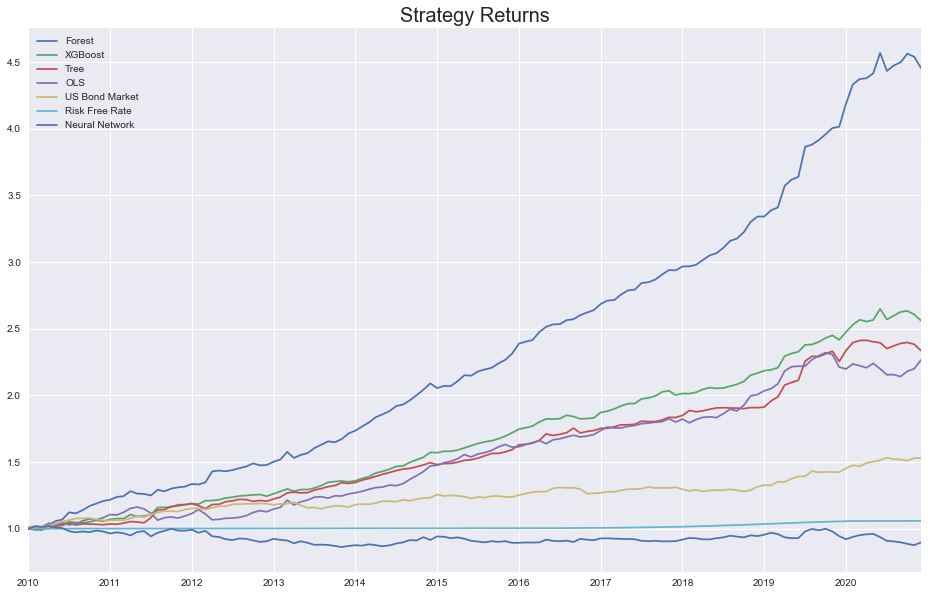

In [206]:
fig, ax = plt.subplots(figsize=(16,10))

ax = returns.plot(ax=ax)
ax.set_title('Strategy Returns', fontsize=20)
ax.set_xlabel("")
ax.set_ylabel("")

plt.show()

# plt.savefig('Strategy Returns.jpg')